In [7]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pointCollection as pc

In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import scattering_deltas as sd
dir(so)
?sd.read_MC_results

In [10]:
%matplotlib notebook

In [ ]:
def limit_zmax(D, z_max=0):
    # the 7th column is maximum depth
    return D[D[:,7] < z_max ]

In [ ]:
D_MC={}
for z_max in [0.5, 1, 1.5, 2, 3, 4, 6, 8, 12, 16, 24, 32, np.Inf]: 
    D_MC[z_max]=sd.read_MC_results('../../scattering_optics/mc_code/1_layer', 
                                   1.e7, filter_fn=limit_zmax, 
                                   filter_args={'z_max':z_max})
    Di=D_MC[z_max]
    Di['P']=Di['E']/(Di['lb']-Di['la'])


In [ ]:
plt.figure()
m={}
τ=np.array(list(D_MC.keys()))
for τi in τ[np.isfinite(τ)]: 
    Di=D_MC[τi]
    Di['P']=Di['E']/(Di['lb']-Di['la'])
    
    els = (Di['E']>1.e-5) & (Di['P'] < 0.5*D_MC[np.Inf]['P'])
    
    hl=plt.semilogy(Di['lc'], Di['P'], label=str(τi))
    plt.plot(Di['lc'][els], Di['P'][els],'.', color=hl[0].get_color())
    
    if np.sum(els) >= 9:
        G=np.c_[np.ones(np.sum(els)), Di['lc'][els]]
        m[τi]=np.linalg.inv(G.T.dot(G)).dot(G.T.dot(np.log(Di['P'][els])))
        
        G1=np.c_[np.ones(len(Di['lc'])), Di['lc']]
        plt.semilogy(Di['lc'], np.exp(G1.dot(m[τi])),'k--')
        
Di=D_MC[np.Inf]
els=(Di['lc']>200) & (Di['lc']<700)
G1=Di['lc'][els]**(-3/2)
m_inf=G1.dot(Di['P'][els])/(G1.T.dot(G1))
plt.plot(Di['lc'], (Di['lc']**(-3/2)).dot(m_inf),'k')

plt.gca().set_ylim([1e-6, 1])
plt.legend()

In [ ]:
τ_layer=np.unique(np.array(list(m.keys())))
k_layer=[m[τ][1] for τ in τ_layer]

In [ ]:
plt.figure();
plt.plot(τ_layer, k_layer)

In [ ]:
t_diverge=[]
for τi in τ[np.isfinite(τ)]:
    Di=D_MC[τi]
    try:
        t_diverge += [( τi, Di['lc'][Di['P'] > 0.995*D_MC[np.inf]['P']][-1] )]
    except Exception:
        pass

t_diverge = np.r_[t_diverge]
G=np.c_[np.ones_like(t_diverge[:,0]), t_diverge[:,0], t_diverge[:,0]**2]
G=G[:,1:]
good=np.all(np.isfinite(G), axis=1) & (t_diverge[:,0] < 3)
G1=G[good,:]
d=t_diverge[good,1]
m_diverge=np.linalg.inv(G1.T.dot(G1)).dot(G1.T.dot(d))
(t_diverge[:,1]-(G.dot(m_diverge)))/(t_diverge[:,1])

In [ ]:
t_diverge[:,1] - G.dot([2, 0])

In [ ]:
plt.figure()
plt.plot(t_diverge[:,0], t_diverge[:,1], marker='.')
plt.plot(t_diverge[:,0], G.dot(m_diverge))
plt.plot(t_diverge[:,0], G.dot([1, 1/3]))


## Notes

$$
t_{diverge} \approx 2 \tau
$$ 
is a good approximation of the profile for $\tau < 3$.

For $\tau$ > 3, 
$$
t_{diverge} \approx \tau + 1/3 \tau^2
$$

The two approximations match for t=3

## Estimating the log slope of the tail:

This is needed to calculate the layer reflectance at infinite time:

### Polynomial fit to infinite medium:

$$
    P_\infty  = A_\infty t^{-3/2}
$$
so
$$
    log(P_\infty) = log(A_\infty) + -3/2 log(t)
$$
$$
    \frac{d}{dt} log(P_\infty)  = -3/(2t)
$$

### semi-log fit to finite layer:

$$
    P_\tau = A_\tau exp(k_\tau t)
$$
so
$$
    log(P_\tau) = log(A_\tau) + k_\tau t
$$
$$
    \frac{d}{dt} log(P_\tau) = k
$$



In [ ]:
τ = np.array(list(m.keys()))
τ=τ[np.isfinite(τ)]
k = np.array([m[τi][1] for τi in τ])
t_div_est = np.zeros_like(τ)
t_div_est[τ<3] = 2*τ[τ<3]
t_div_est[τ>=3] = τ[τ>=3]+1/3*τ[τ>=3]**2

k_est0=np.zeros_like(t_div_est)
for count, ti in enumerate(t_div_est):
    ind=np.searchsorted(D_MC[np.Inf]['lc'], [0.9*ti, 1.1*ti])
    k_est0[count] = np.diff(np.log(D_MC[np.Inf]['P'][ind]))/np.diff(D_MC[np.Inf]['lc'][ind])
    
k_est1 = -3/(2*t_div_est)

plt.figure()
plt.semilogx(τ, k,'.', label='fit to MC')
plt.semilogx(τ, k_est0, label='tangent for infinite medium')
plt.semilogx(τ, k_est1, label='tangent for finite medium')
plt.legend()


In [ ]:
plt.figure()
plt.plot(τ,k_est0/k, label='semi-infinite')
plt.plot(τ,k_est1/k, label='finite')
plt.legend()
plt.gca().set_ylabel('est k / k')

###  Notes
For small τ, we can measure the decay directly.  For τ>16, the decay rate estimated from the infinite medium is about 20% too large, which is probably fine.  We can use 20% +- 10% as our estimate for the slope and its error bound.

The results are, then:

  -For thin layers (τ < 6), calculate the reflectance from the available photon returns for bins where N>100.  
  
  -For medium layers ($6 \le τ \lt 16$), calculate the reflectance from the avaliable photons.  To check the approximations above, calculate:
$$
  P_{tail, est}(t) = P_{\inf}(t_{div})exp(-\frac{3}{2t_{div}} (t-t_{div}))
$$
so
$$
    E_{tail, est} = P_{\inf}(t_{div})\frac{2t_{div}}{3}
$$

 -For thicker layers ($ τ \gt 16$), integrate the $t^{-3/2}$ curve from the last time value in the calculated waveform, $t_{n}$, to $t_{div}$:
 $$
     E_{tail,0}=-\frac{1}{2} P_0(t_{div}^{-1/2} - t_{n}^{-1/2}) 
 $$
 and add $E_{tail, est}$ from above.
 
 ### Testing:

In [ ]:
# calculate P0, the power at time zero for the t^-3/2 curve:
L_max=1900
tail = (D_MC[np.Inf]['lc'] > 200) & (D_MC[np.Inf]['lc'] < L_max)
G_tail = D_MC[np.Inf]['lc'][tail]**(-3/2)
d_tail = D_MC[np.Inf]['P'][tail]
P0_inf = 1/(G_tail.dot(G_tail))*(G_tail.T.dot(D_MC[np.Inf]['P'][tail]));

In [ ]:
plt.figure()
plt.semilogy(D_MC[np.Inf]['lc'], D_MC[np.Inf]['P'],'.')
plt.semilogy(D_MC[np.Inf]['lc'][tail], G_tail*P0_inf)

### Check that the total reflected energy is ~1 for an infinite medium with no absorption (right?)

In [ ]:
R_inf = 2*P0_inf*D_MC[np.Inf]['lc'][-1]**(-1/2)
R_inf+np.sum(D_MC[np.Inf]['E'])

In [12]:
import scattering_optics as so

In [17]:
D_MC=so.read_MC_results('../../scattering_optics/mc_code/1_layer', τ=1, N_MC=1.e7)

In [18]:
D_MC['norm']

5e-08

<IPython.core.display.Javascript object>


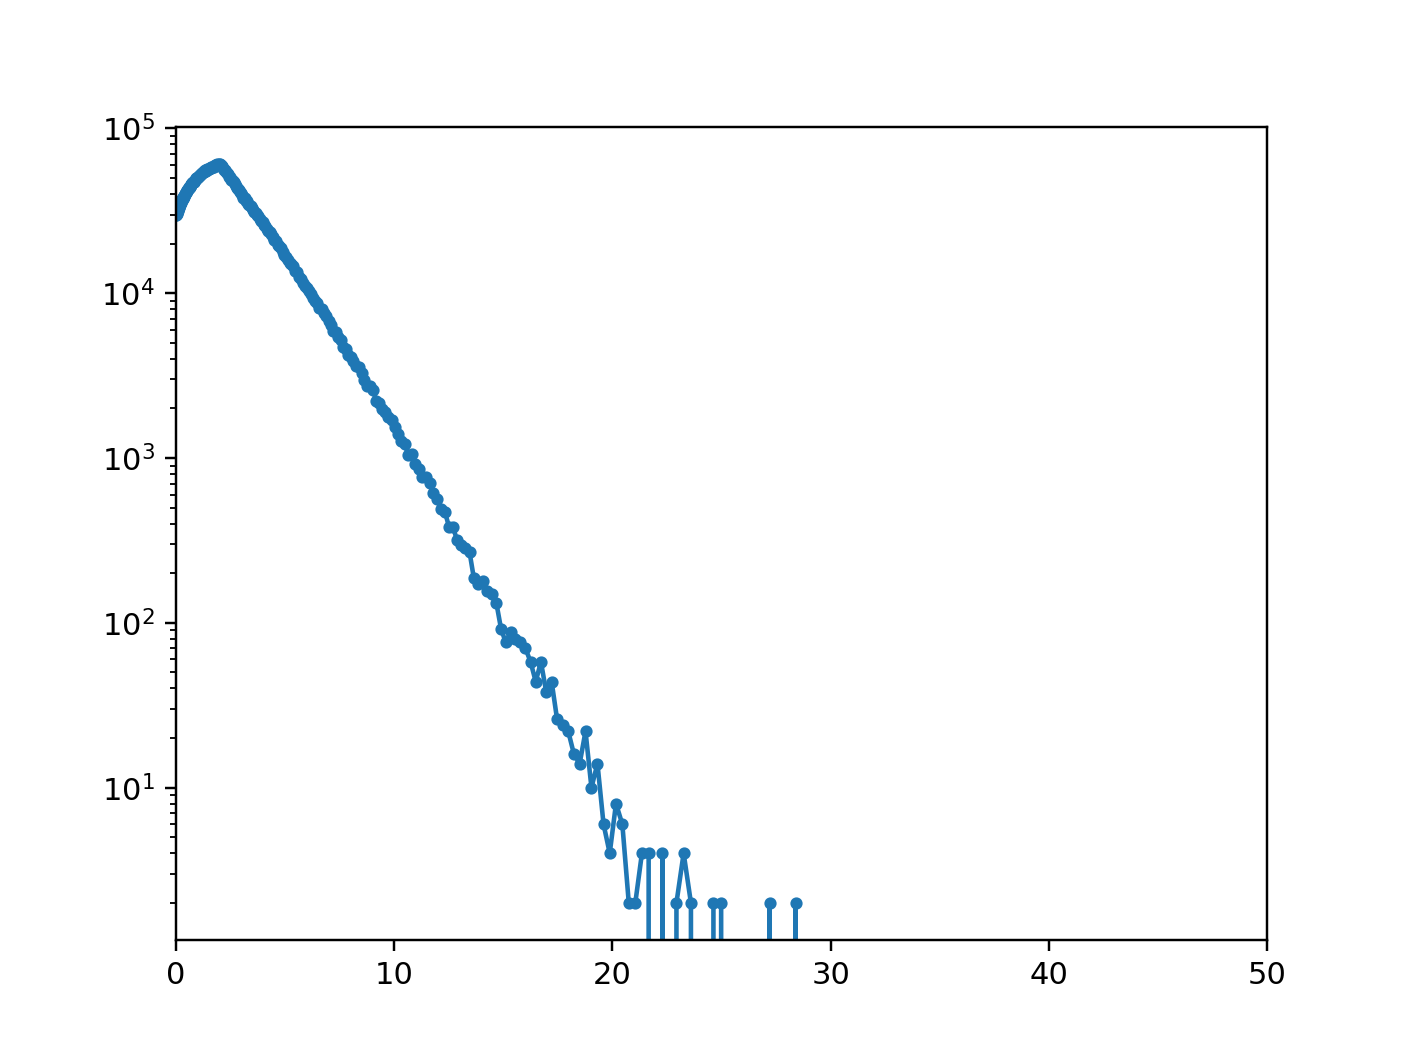

(0.0, 50.0)

In [25]:
plt.figure()
plt.semilogy(D_MC['lc'], D_MC['E']/D_MC['norm'],marker='.')
plt.gca().set_xlim([0, 50])

'/Users/ben/git_repos/ATM_waveform/notebooks'